In [1]:
import numpy as np
import pandas as pd
import scipy.optimize
import scipy.stats as st
import numba

import corner
import bebi103

import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)
%matplotlib inline

In [2]:
df = pd.read_csv('../data/finch_beaks.csv', comment='#')

In [3]:
df.head()

,band,species,beak length (mm),beak depth (mm),year
0,20123,fortis,9.25,8.05,1973
1,20126,fortis,11.35,10.45,1973
2,20128,fortis,10.15,9.55,1973
3,20129,fortis,9.95,8.75,1973
4,20133,fortis,11.55,10.15,1973


7.2 PART B

In [4]:
# Filter to get scandens
inds = df['species'] == 'scandens' 
allScandens = df.loc[inds,: ]
allScandens.head()

,band,species,beak length (mm),beak depth (mm),year
73,20121,scandens,15.15,9.35,1973
74,20125,scandens,15.05,9.75,1973
75,20135,scandens,14.45,8.35,1973
76,20159,scandens,14.05,9.55,1973
77,20160,scandens,14.25,8.55,1973


In [5]:
# Get all scandens in 1975
inds1975 = allScandens['year'] == 1975
scandens1975 = allScandens.loc[inds1975, :]
scandens1975.head()

,band,species,beak length (mm),beak depth (mm),year
405,302,scandens,13.9,8.4,1975
406,304,scandens,14.0,8.8,1975
407,306,scandens,12.9,8.4,1975
408,310,scandens,13.5,8.0,1975
409,317,scandens,12.9,7.9,1975


In [6]:
# Get all scandens in 2012
inds2012 = allScandens['year'] == 2012
scandens2012 = allScandens.loc[inds2012, :]
scandens2012.head()

,band,species,beak length (mm),beak depth (mm),year
2177,19026,scandens,14.3,9.4,2012
2178,19028,scandens,12.5,8.9,2012
2179,19029,scandens,13.7,9.5,2012
2180,19094,scandens,13.8,11.0,2012
2181,19122,scandens,12.0,8.7,2012


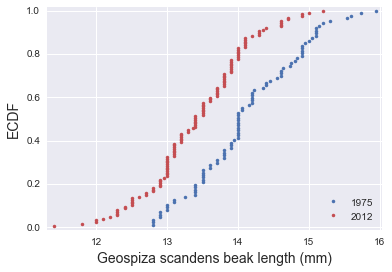

In [7]:
# Store data as Numpy arrays for speed later
s1975 = scandens1975['beak length (mm)'].values
s2012 = scandens2012['beak length (mm)'].values

# Get x-y values for ECDF
x_control, y_control = bebi103.ecdf(s1975)
x_pest, y_pest = bebi103.ecdf(s2012)

# Make plots
plt.plot(x_control, y_control, marker='.', linestyle='none')
plt.plot(x_pest, y_pest, marker='.', linestyle='none', 
         color=sns.color_palette()[2])
plt.margins(0.02)
plt.xlabel('Geospiza scandens beak length (mm)')
plt.ylabel('ECDF')
plt.legend(('1975', '2012'), loc='lower right');

This is the ECDF for Geospiza scandens beak length of 1975 and 2012.

In [8]:
print("The means of beak lengths from our data: \n" + str(sum(s1975) / len(s1975)) + " mm for 1975.")
print (str(sum(s2012) / len(s2012)) + " mm for 2012.")
print ("\nWe estimate mean lengths below.")

The means of beak lengths from our data: 
14.1209195402 mm for 1975.
13.421023622 mm for 2012.

We estimate mean lengths below.


In [9]:
@numba.jit(nopython=True)
def draw_bs_sample(data):
    """
    Draw a bootstrap sample from a 1D data set.
    """
    return np.random.choice(data, size=len(data))

In [10]:
def draw_bs_reps(data, stat_fun, size=10000):
    """
    Draw boostrap replicates computed with stat_fun from 1D data set.
    """
    return np.array([stat_fun(draw_bs_sample(data)) for _ in range(size)])


@numba.jit(nopython=True)
def draw_bs_reps_mean(data, size=10000):
    """
    Draw boostrap replicates of the mean from 1D data set.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.mean(draw_bs_sample(data))
    return out


@numba.jit(nopython=True)
def draw_bs_reps_median(data, size=10000):
    """
    Draw boostrap replicates of the median from 1D data set.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.median(draw_bs_sample(data))
    return out

@numba.jit(nopython=True)
def draw_bs_reps_std(data, size=10000):
    """
    Draw boostrap replicates of the standard deviation from 1D data set.
    """
    out = np.empty(size)
    for i in range(size):
        out[i] = np.std(draw_bs_sample(data))
    return out

In [11]:
bs_reps_mean_1975 = draw_bs_reps_mean(s1975)
bs_reps_mean_2012 = draw_bs_reps_mean(s2012)
meanEstimate1975 = sum(list(bs_reps_mean_1975)) / len(list(bs_reps_mean_1975))
meanEstimate2012 = sum(list(bs_reps_mean_2012)) / len(list(bs_reps_mean_2012))

In [12]:
print ("Average of the bootstrap replicates for the means of the two years.\n")

print("The mean estimate for beak length of Geospiza scandens in 1975 is " + str(meanEstimate1975) + " mm.")
print("The mean estimate for beak length of Geospiza scandens in 2012 is " + str(meanEstimate2012) + " mm.")

Average of the bootstrap replicates for the means of the two years.

The mean estimate for beak length of Geospiza scandens in 1975 is 14.1191967816 mm.
The mean estimate for beak length of Geospiza scandens in 2012 is 13.4204354331 mm.


In [13]:
# 95% confidence intervals
mean_1975 = np.percentile(bs_reps_mean_1975, [2.5, 97.5])
mean_2012 = np.percentile(bs_reps_mean_2012, [2.5, 97.5])

print("""
Mean 1975 Geospiza scandens beak length 95% conf int (mm):   [{0:.2f}, {1:.2f}]
Mean 2012 Geospiza scandens beak length 95% conf int (mm): [{2:.2f}, {3:.2f}]
""".format(*(tuple(mean_1975) + tuple(mean_2012))))


Mean 1975 Geospiza scandens beak length 95% conf int (mm):   [13.96, 14.28]
Mean 2012 Geospiza scandens beak length 95% conf int (mm): [13.29, 13.54]



7.2 PART C

7.2 PART D

The scalar value for beak shape is (1/2) x beak length x beak depth. We can think of beak shape as being analagous to the area of a finch beak if laid on a two dimensional plane. The beak resembles that of a triangle with base of length beak depth and height of beak length and to get the area, we do 1/2 x base x height = 1/2 x beak length x beak depth.

In [14]:
lengths = list(df['beak length (mm)'])
widths = list(df['beak depth (mm)'])
shape = []
for i in range(len(lengths)):
    shape.append(0.5 * lengths[i] * widths[i])

In [15]:
df['Beak shape'] = shape

In [16]:
df.head()

,band,species,beak length (mm),beak depth (mm),year,Beak shape
0,20123,fortis,9.25,8.05,1973,37.23125
1,20126,fortis,11.35,10.45,1973,59.30375
2,20128,fortis,10.15,9.55,1973,48.46625
3,20129,fortis,9.95,8.75,1973,43.53125
4,20133,fortis,11.55,10.15,1973,58.61625


We now have an updated dataframe with a new column for our scalar "Beak shape" as shown above.

For the open-ended portion of this question, we are going to compare the two species in ~20 year intervals (1973, 1991, 2012) and see how the species compare against one another each of these years and how each species compares with itself over time.

In [17]:
# Filter to get fortis
inds = df['species'] == 'fortis' 
allFortis = df.loc[inds,: ]
allFortis.head()

,band,species,beak length (mm),beak depth (mm),year,Beak shape
0,20123,fortis,9.25,8.05,1973,37.23125
1,20126,fortis,11.35,10.45,1973,59.30375
2,20128,fortis,10.15,9.55,1973,48.46625
3,20129,fortis,9.95,8.75,1973,43.53125
4,20133,fortis,11.55,10.15,1973,58.61625


In [18]:
# Filter to get fortis
inds = df['species'] == 'scandens' 
allScandens = df.loc[inds,: ]
allScandens.head()

,band,species,beak length (mm),beak depth (mm),year,Beak shape
73,20121,scandens,15.15,9.35,1973,70.82625
74,20125,scandens,15.05,9.75,1973,73.36875
75,20135,scandens,14.45,8.35,1973,60.32875
76,20159,scandens,14.05,9.55,1973,67.08875
77,20160,scandens,14.25,8.55,1973,60.91875


In [19]:
# Filter to get data corresponding to years 1973, 1991, and 2012 of scanden species
inds1973 = allScandens['year'] == 1973
scandens1973 = allScandens.loc[inds1973, :]

inds1991 = allScandens['year'] == 1991
scandens1991 = allScandens.loc[inds1991, :]

inds2012 = allScandens['year'] == 2012
scandens2012 = allScandens.loc[inds2012, :]

In [20]:
# Filter to get data corresponding to years 1973, 1991, and 2012 of fortis species

inds1973 = allFortis['year'] == 1973
fortis1973 = allFortis.loc[inds1973, :]

inds1991 = allFortis['year'] == 1991
fortis1991 = allFortis.loc[inds1991, :]

inds2012 = allFortis['year'] == 2012
fortis2012 = allFortis.loc[inds2012, :]


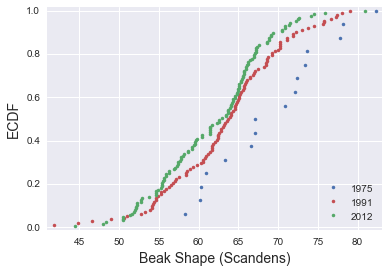

In [21]:
# Store data as Numpy arrays for speed later
s1973 = scandens1973['Beak shape'].values
s1991 = scandens1991['Beak shape'].values
s2012 = scandens2012['Beak shape'].values
# Get x-y values for ECDF
x_control, y_control = bebi103.ecdf(s1973)
x_pest, y_pest = bebi103.ecdf(s1991)
x_pest1, y_pest1 = bebi103.ecdf(s2012)

# Make plots
plt.plot(x_control, y_control, marker='.', linestyle='none')
plt.plot(x_pest, y_pest, marker='.', linestyle='none', 
         color=sns.color_palette()[2])
plt.plot(x_pest1, y_pest1, marker='.', linestyle='none', 
         color=sns.color_palette()[1])
plt.margins(0.02)
plt.xlabel('Beak Shape (Scandens)')
plt.ylabel('ECDF')
plt.legend(('1975', '1991', '2012'), loc='lower right');

Just visually looking at the ECDF, it appears that the beak shape has gotten smaller with time. Let's do another ECDF for the other species for the same years. 

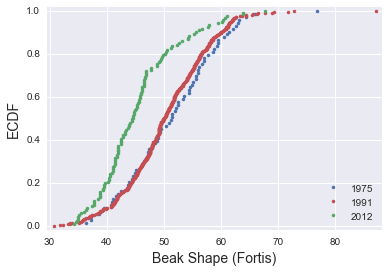

In [22]:
# Store data as Numpy arrays for speed later
f1973 = fortis1973['Beak shape'].values
f1991 = fortis1991['Beak shape'].values
f2012 = fortis2012['Beak shape'].values
# Get x-y values for ECDF
x_control, y_control = bebi103.ecdf(f1973)
x_pest, y_pest = bebi103.ecdf(f1991)
x_pest1, y_pest1 = bebi103.ecdf(f2012)

# Make plots
plt.plot(x_control, y_control, marker='.', linestyle='none')
plt.plot(x_pest, y_pest, marker='.', linestyle='none', 
         color=sns.color_palette()[2])
plt.plot(x_pest1, y_pest1, marker='.', linestyle='none', 
         color=sns.color_palette()[1])
plt.margins(0.02)
plt.xlabel('Beak Shape (Fortis)')
plt.ylabel('ECDF')
plt.legend(('1975', '1991', '2012'), loc='lower right');

We see a similar trend in the Fortis species, but a more drastic drop in beak shape from 1991 to 2012 and a smaller decrease in beak shape from 1975 to 1991. This may be attributed to the severe drought in 1976 and 1977 explored in part (c).

We will now keep the year constant, and plot ECDFs of the two species against one another for each year.

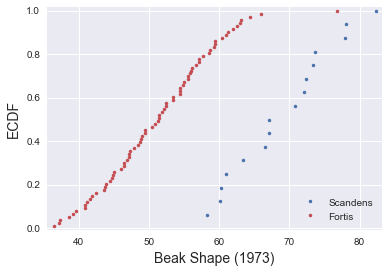

In [23]:
# Store data as Numpy arrays for speed later
s1973 = scandens1973['Beak shape'].values
f1973 = fortis1973['Beak shape'].values

# Get x-y values for ECDF
x_control, y_control = bebi103.ecdf(s1973)
x_pest, y_pest = bebi103.ecdf(f1973)


# Make plots
plt.plot(x_control, y_control, marker='.', linestyle='none')
plt.plot(x_pest, y_pest, marker='.', linestyle='none', 
         color=sns.color_palette()[2])

plt.margins(0.02)
plt.xlabel('Beak Shape (1973)')
plt.ylabel('ECDF')
plt.legend(('Scandens', 'Fortis'), loc='lower right');

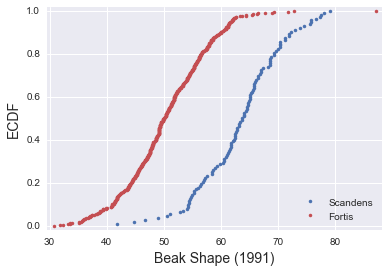

In [24]:
# Store data as Numpy arrays for speed later
s1991 = scandens1991['Beak shape'].values
f1991 = fortis1991['Beak shape'].values

# Get x-y values for ECDF
x_control, y_control = bebi103.ecdf(s1991)
x_pest, y_pest = bebi103.ecdf(f1991)


# Make plots
plt.plot(x_control, y_control, marker='.', linestyle='none')
plt.plot(x_pest, y_pest, marker='.', linestyle='none', 
         color=sns.color_palette()[2])

plt.margins(0.02)
plt.xlabel('Beak Shape (1991)')
plt.ylabel('ECDF')
plt.legend(('Scandens', 'Fortis'), loc='lower right');

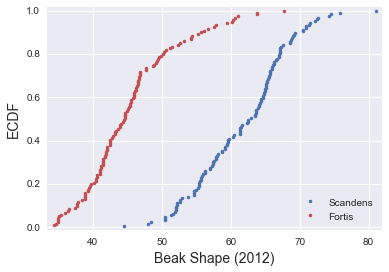

In [25]:
# Store data as Numpy arrays for speed later
s2012 = scandens2012['Beak shape'].values
f2012 = fortis2012['Beak shape'].values

# Get x-y values for ECDF
x_control, y_control = bebi103.ecdf(s2012)
x_pest, y_pest = bebi103.ecdf(f2012)


# Make plots
plt.plot(x_control, y_control, marker='.', linestyle='none')
plt.plot(x_pest, y_pest, marker='.', linestyle='none', 
         color=sns.color_palette()[2])

plt.margins(0.02)
plt.xlabel('Beak Shape (2012)')
plt.ylabel('ECDF')
plt.legend(('Scandens', 'Fortis'), loc='lower right');

Just looking at the ECDFs comparing the two species over time, it seems that finches of the specie Fortis have larger beak shapes than those of species Scandens. 

Now, to get some actual quantites, we will provide estimates for mean and confidence intervals for both species in each of the three years chosen (1973, 19991, and 2012).

In [26]:
# Mean estimates for scandens

bs_reps_mean_1973s = draw_bs_reps_mean(s1973)
bs_reps_mean_1991s = draw_bs_reps_mean(s1991)
bs_reps_mean_2012s = draw_bs_reps_mean(s2012)

meanEstimate1973s = sum(list(bs_reps_mean_1973s)) / len(list(bs_reps_mean_1973s))
meanEstimate1991s = sum(list(bs_reps_mean_1991s)) / len(list(bs_reps_mean_1991s))
meanEstimate2012s = sum(list(bs_reps_mean_2012s)) / len(list(bs_reps_mean_2012s))

# 95% confidence intervals for scandens
mean_1973s = np.percentile(bs_reps_mean_1973s, [2.5, 97.5])
mean_1991s = np.percentile(bs_reps_mean_1991s, [2.5, 97.5])
mean_2012s = np.percentile(bs_reps_mean_2012s, [2.5, 97.5])
# Mean estimates for fortis

bs_reps_mean_1973f = draw_bs_reps_mean(f1973)
bs_reps_mean_1991f = draw_bs_reps_mean(f1991)
bs_reps_mean_2012f = draw_bs_reps_mean(f2012)

meanEstimate1973f = sum(list(bs_reps_mean_1973f)) / len(list(bs_reps_mean_1973f))
meanEstimate1991f = sum(list(bs_reps_mean_1991f)) / len(list(bs_reps_mean_1991f))
meanEstimate2012f = sum(list(bs_reps_mean_2012f)) / len(list(bs_reps_mean_2012f))

# 95% confidence intervals for fortis
mean_1973f = np.percentile(bs_reps_mean_1973f, [2.5, 97.5])
mean_1991f = np.percentile(bs_reps_mean_1991f, [2.5, 97.5])
mean_2012f = np.percentile(bs_reps_mean_2012f, [2.5, 97.5])

print("""
1973 scandens beak shape mean: {:.2f}. The 95% conf int (mm^2): {:.2f}, {:.2f}
1991 scandens beak shape mean: {:.2f}. The 95% conf int (mm^2): {:.2f}, {:.2f}
2012 scandens beak shape mean: {:.2f}. The 95% conf int (mm^2): {:.2f}, {:.2f}

""".format(meanEstimate1973s, mean_1973s[0], mean_1973s[1], meanEstimate1991s, mean_1991s[0], mean_1991s[1], meanEstimate2012s, mean_2012s[0], mean_2012s[1])) 
print("""
1973 fortis beak shape mean: {:.2f}. The 95% conf int (mm^2): {:.2f}, {:.2f}
1991 fortis beak shape mean: {:.2f}. The 95% conf int (mm^2): {:.2f}, {:.2f}
2012 fortis beak shape mean: {:.2f}. The 95% conf int (mm^2): {:.2f}, {:.2f}

""".format(meanEstimate1973f, mean_1973f[0], mean_1973f[1], meanEstimate1991f, mean_1991f[0], mean_1991f[1], meanEstimate2012f, mean_2012f[0], mean_2012f[1])) 




1973 scandens beak shape mean: 69.06. The 95% conf int (mm^2): 65.66, 72.50
1991 scandens beak shape mean: 63.38. The 95% conf int (mm^2): 62.02, 64.71
2012 scandens beak shape mean: 61.76. The 95% conf int (mm^2): 60.60, 62.90



1973 fortis beak shape mean: 51.29. The 95% conf int (mm^2): 49.48, 53.13
1991 fortis beak shape mean: 50.34. The 95% conf int (mm^2): 49.69, 50.98
2012 fortis beak shape mean: 45.47. The 95% conf int (mm^2): 44.26, 46.75




With actual quantitative estimates, a lot of what we speculated in the plotting of our ECDFs appear to be supported. Among each species, we see decreasing beak shape means as time goes by and for each year, we see that scandens have a larger mean than fortis.

Let's now conduct some hypothesis tests and generate some p-values.

**7.2 PART E**

In [27]:
dfScandens = pd.read_csv('../data/scandens_beak_depth_heredity.csv', comment='#')
dfFortis = pd.read_csv('../data/fortis_beak_depth_heredity.csv', comment='#')

In [47]:
mid_parentS = np.asarray(dfScandens['mid_parent'].values)
mid_offS = np.asarray(dfScandens['mid_offspring'].values)
dfScandens.head()

,mid_parent,mid_offspring
0,8.3318,8.4190
1,8.4035,9.2468
2,8.5317,8.1532
3,8.7202,8.0089
4,8.7089,8.2215


In [29]:
mid_parentF = []
maleBD = dfFortis['Male BD']
femaleBD = dfFortis['Female BD']
for i in range(len(maleBD)):
    mid_parentF.append((maleBD[i] + femaleBD[i]) / 2)
dfFortis['mid_parent'] = mid_parentF
mid_parentF = np.asarray(mid_parentF)
mid_offF = np.asarray(dfFortis['Mid-offspr'].values)

In [30]:
dfFortis.head()

,Mid-offspr,Male BD,Female BD,mid_parent
0,10.70,10.90,9.3,10.100
1,9.78,10.70,8.4,9.550
2,9.48,10.70,8.1,9.400
3,9.60,10.70,9.8,10.250
4,10.27,9.85,10.4,10.125


Note we have an extra column (called 'mid_parent') now, that stores the average of parent beak depth: $\frac{\text{Male BD + Female BD}}{2}$.

In [56]:
def calculateRatio(parents, offspring):
    variance = np.var(parents)
    covariance = np.cov(parents, offspring)
    cov = covariance[0,1]
    return cov/variance

In [57]:
def returnBootStrapPairs(x, y):
    n = len(x)
    inds = np.arange(n)
    bs_inds = np.random.choice(inds, size=n)
    bs_x, bs_y = x[bs_inds], y[bs_inds]
    return bs_x, bs_y

In [104]:
# We will now determine mean and confidence intervals for the Scanden species
ratioS = []

for i in range(10000): # 10000 bootstrap runs
    parent, off = returnBootStrapPairs(mid_parentS, mid_offS) # This function swaps indices to keep parent/offspring pairing
    ratioS.append(calculateRatio(parent, off))
totalSum = 0
for j in ratioS:
    totalSum += np.mean(j)
meanEstimateS = totalSum/ len(ratioS)  #Calculate mean estimate
confidenceIntervalS = np.percentile(ratioS, [2.5, 97.5])  #Calculate CI

In [105]:
# We will now determine mean and confidence intervals for the Scanden species
ratioF = []

for i in range(100000):
    parent, off = returnBootStrapPairs(mid_parentF, mid_offF)
    ratioF.append(calculateRatio(parent, off))
totalSum = 0
for j in ratioF:
    totalSum += np.mean(j)
meanEstimateF = totalSum/ len(ratioF)
confidenceIntervalF = np.percentile(ratioF, [2.5, 97.5])

In [107]:
print("""
Scandens heritability ratio mean: {:.3f}. The 95% conf int : [{:.3f}, {:.3f}]
Fortis heritability ratio mean: {:.3f}. The 95% conf int : [{:.3f}, {:.3f}]

""".format(meanEstimateS, confidenceIntervalS[0], confidenceIntervalS[1], meanEstimateF, confidenceIntervalF[0], confidenceIntervalF[1]))


Scandens heritability ratio mean: 0.554. The 95% conf int : [0.350, 0.761]
Fortis heritability ratio mean: 0.725. The 95% conf int : [0.648, 0.799]




Introgressive hybridization seems likely. It appears that the Fortis species has a higher heritability ratio than that of the Scanden species. We should take note that the Scandens species has a much larger confidence interval than that of the Fortis species, and furthermore, the fortis heritability ratio mean lies in the scandens 95% confidence interval. Thus, although the Fortis species has a higher heritability ratio, this difference is not signicant at the 95% confidence level.

From the given definition of heritability, this would suggest that, although not significant, the Fortis species is more apt at repeated backcrossing and transferring the specific trait of beak depth to the other Scandens species. Perhaps, over many generations, the Scandens may start having beak depths resembling that of Fortis. 